In [1]:
import xarray as xr
import postmit as pm
import numpy as np
from matplotlib import pyplot as plt
from cmocean import cm

In [2]:
path_to_data = "/path/to/data/"
path_to_input = "/path/to/input/"

### Load some data
Here we load data that has already been converted to `netCDF` format with [`convert.convert2nc`](https://github.com/jk-rieck/postmit/blob/main/examples/example_convert.ipynb).

In [3]:
ds = xr.merge([xr.open_dataset(path_to_data + "2D_diags.nc"), xr.open_dataset(path_to_data + "3D_diags.nc"), 
               xr.open_dataset(path_to_data + "ice_diags.nc"), xr.open_dataset(path_to_data + "layers_diags.nc")])

### Apply some checks
Here we will apply all checks with [`checks.apply_all_checks`](https://github.com/jk-rieck/postmit/blob/main/postmit/checks.py#L137).  
See [example_checks.ipynb](https://github.com/jk-rieck/postmit/blob/main/examples/example_checks.ipynb) for more details.

In [4]:
ds = pm.checks.apply_all_checks(ds, path_to_input)

### The quantities that can be computed:

| variable          | description                                                  | grid               | units      | function          | depends on                          |
| :-                | :-                                                           | :-                 |            | :-                | :-                                  |
| VORT              | vorticity                                                    | (time, Z, YG, XG)  | 1/s        | vort              | UVEL, VVEL, `xgcm`                  |
| RosNum            | Rossby number                                                | (time, Z, YG, XG)  |            | rossby_num        | VORT, fU                            |
| UTRANS            | mean zonal transport integrated over Y and Z                 | (time)             | m^3/s      | transports        | UVEL, `xgcm`                        |
| VTRANS            | mean meridional transport integrated over X and Z            | (time)             | m^3/s      | transports        | VVEL, `xgcm`                        |
| UVELbot           | zonal velocity at the bottom (deepest ocean grid cell)       | (time, Z, YC, XG)  | m/s        | transports        | UVEL                                |
| VVELbot           | meridional velocity at the bottom (deepest ocean grid cell)  | (time, Z, YG, XC)  | m/s        | transports        | VVEL                                |
| UTRANSbaro        | mean zonal baroclinic transport integrated over Y and Z      | (time)             | m^3/s      | transports        | `xgcm`, UVELbot                     |
| VTRANSbaro        | mean meridional baroclinic transport integrated over X and Z | (time)             | m^3/s      | transports        | `xgcm`, VVELbot                     |
| SIG0              | potential density referenced to the surface (0 dbar)         | (time, Z, YC, XC)  | kg/m^3     | sig0              | SALT, THETA, `MITgcmutils`          |
| SIGi              | potential density referenced to `i * 1000` dbar (`i < 10`)   | (time, Z, YC, XC)  | kg/m^3     | sigi              | SALT, THETA, `MITgcmutils`          | 
| MOC               | meridional overturning circulation                           | (time, Z, YG)      | m^3/s      | total_MOC         | VVEL, `xgcm`                        |
| MOC_res           | residual meridional overturning circulation                  | (time, layer_center, YG) | m^3/s| residual_MOC      | `LAYERS` package, LaVH1RHO, `xgcm`  |
| MOC_res_z         | residual meridional overturning in depth space               | (time, Z, YG)      | m^3/s      | residual_MOC      | `LAYERS` package, LaVH1RHO, `xgcm`  |
| gravity           | gravity used in the simulation (default=9.81)                |                    | m/s^2      | get_const         |                                     |
| rhonil            | rhonil used in the simulation (default=999.8                 |                    | kg/m^3     | get_const         |                                     |
| rhoconst          | rhoconst used in the simulation (default=rhonil)             |                    | kg/m^3     | get_const         |                                     |
| HeatCapacity_cp   | HeatCapacity_cp used in the simulation (default=3994)        |                    | J/kg/K     | get_const         |                                     |
| ups               | scale factor to convert model salinity to preformed          |                    |            | get_const         |                                     |
| fF                | coriolis parameter on t grid                                 | (time, Z, YC, XC)  | 1/s        | get_const         |                                     |
| fG                | coriolis parameter on v grid                                 | (time, Z, YG, XC)  | 1/s        | get_const         |                                     |
| fC                | coriolis parameter on u grid                                 | (time, Z, YC, XG)  | 1/s        | get_const         |                                     |
| fU                | coriolis parameter on f grid                                 | (time, Z, YG, XG)  | 1/s        | get_const         |                                     |
| SEAICE_waterDrag  | drag coefficient for stress between ice and water            |                    |            | get_const         | `SEAICE` package                    |
| BUOY              | buoyancy                                                     | (time, Z, YC, XC)  | m/s^2      | buoy              | RHOAnoma, gravity, rhoconst         |
| PRESS             | pressure                                                     | (time, Z, YC, XC)  | dbar       | press             | PHIHYD, rhonil                      |
| DENS              | in-situ density                                              | (time, Z, YC, XC)  | kg/m^3     | dens              | SALT, THETA, PRESS, `MITgcmutils`   |
| SA                | absolute salinity                                            | (time, Z, YC, XC)  | g/kg       | SA                | `gsw`, SALT, ups, PRESS, lonF, latF |
| alpha             | thermal expansion coefficient                                | (time, Z, YC, XC)  | 1/K        | alpha             | `gsw`, SA, THETA, PRESS             |
| beta              | haline contraction coefficient                               | (time, Z, YC, XC)  | kg/g       | beta              | `gsw`, SA, THETA, PRESS             |
| BFlx_SURF         | surface buoyancy flux                                        | (time, Z, YC, XC)  |            | surface_buoy_flux | gravity, rhoconst, HeatCapacity_Cp, SA, alpha, beta, oceQnet, oceFWflx |
| WVELEk            | Ekman vertical velocity                                      | (time, Z, YG, XG)  | m/s        | w_ekman           | rhoconst, `xgcm`, VORT, EXFtaux, EXFtauy |
| SIOtaux           | zonal sea ice-ocean stress                                   | (time, Z, YC, XG)  | N/m^2      | ice_ocean_stress  | rhoconst, SEAICE_waterDrag, SIuice, UVEL, SIheff, SIarea |
| SIOtauy           | meridional sea ice-ocean stress                              | (time, Z, YG, XC)  | N/m^2      | ice_ocean_stress  | rhoconst, SEAICE_waterDrag, SIvice, VVEL, SIheff, SIarea |

All the quantities will be added to the existing dataset.

### Some examples

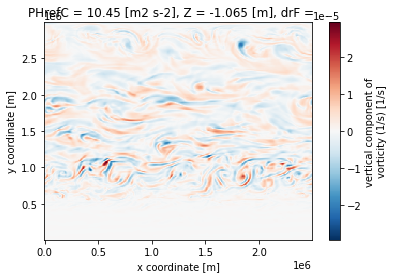

In [5]:
ds = pm.calcs.vort(ds)
ds.VORT.isel(time=0, Z=0, YG=slice(1,None)).plot()

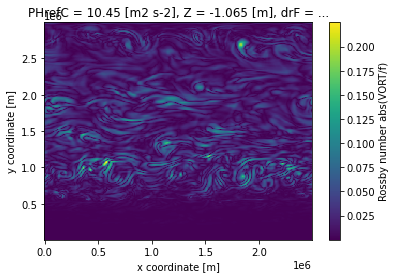

In [6]:
ds = pm.calcs.rossby_num(ds, path_to_input=path_to_input)
ds.RosNum.isel(time=0, Z=0, YG=slice(1,None)).plot()

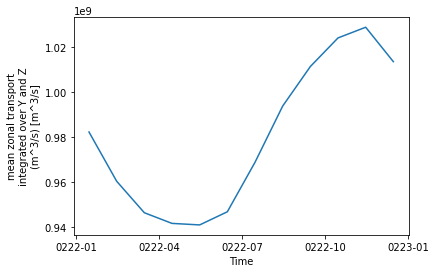

In [7]:
ds = pm.calcs.transports(ds)
ds.UTRANS.plot()

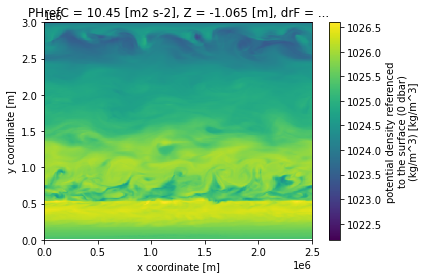

In [8]:
ds = pm.calcs.sig0(ds)
ds.SIG0.where(ds.maskC==1).isel(time=0, Z=0).plot()

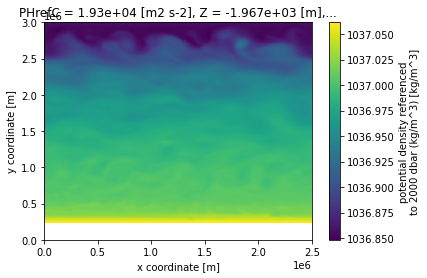

In [9]:
ds = pm.calcs.sigi(ds, 2)
ds.SIG2.where(ds.maskC==1).isel(time=0, Z=40).plot()

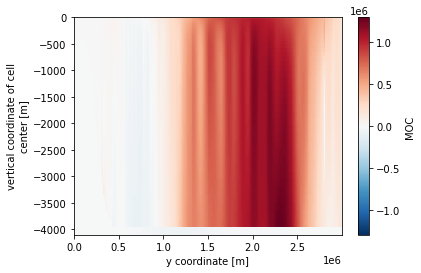

In [10]:
ds = pm.calcs.total_MOC(ds)
ds.MOC.mean("time").plot()

/home/jan/miniconda3/envs/py3_postmit/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:170: RuntimeWarning: invalid value encountered in _interp_1d_linear
  return self.ufunc(*args, **kwargs)


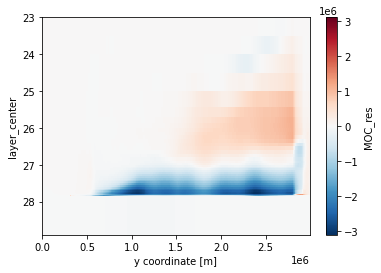

In [11]:
ds = pm.calcs.residual_MOC(ds, path_to_input=path_to_input)
ds.MOC_res.mean("time").plot(yincrease=False)

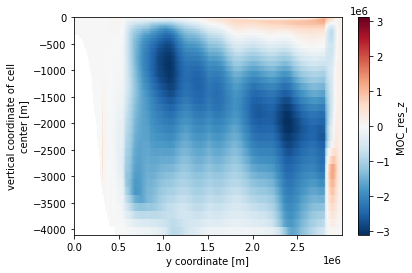

In [12]:
ds.MOC_res_z.mean("time").plot()

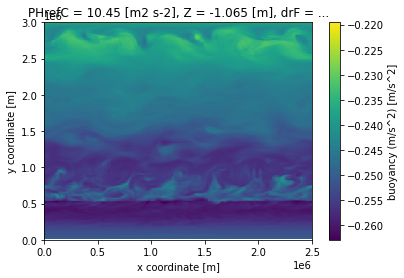

In [13]:
ds = pm.calcs.buoy(ds, path_to_input=path_to_input)
ds.BUOY.where(ds.maskC==1).isel(time=0, Z=0).plot()

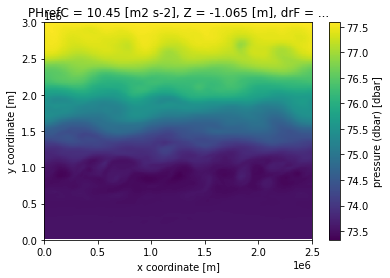

In [14]:
ds = pm.calcs.press(ds, path_to_input=path_to_input)
ds.PRESS.where(ds.maskC==1).isel(time=0, Z=0).plot()

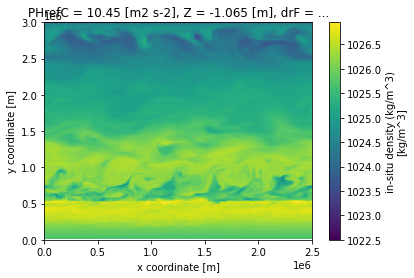

In [15]:
ds = pm.calcs.dens(ds, path_to_input=path_to_input)
ds.DENS.where(ds.maskC==1).isel(time=0, Z=0).plot()

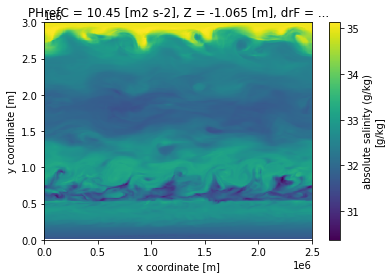

In [16]:
ds = pm.calcs.SA(ds, path_to_input=path_to_input, latmin=-75, latmax=-35, lonmin=-30, lonmax=-30)
ds.SA.where(ds.maskC==1).isel(time=0, Z=0).plot()

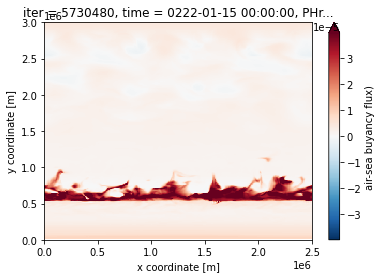

In [19]:
ds = pm.calcs.surface_buoy_flux(ds, path_to_input=path_to_input, latmin=-75, latmax=-35, lonmin=-30, lonmax=-30)
ds.BFlx_SURF.where(ds.maskC==1).isel(time=0, Z=0).plot(robust=True)

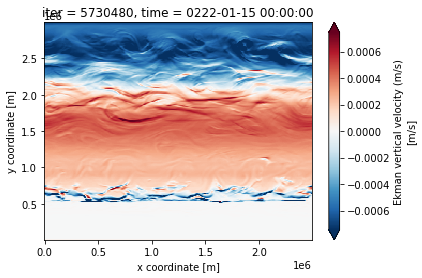

In [26]:
ds = pm.calcs.w_ekman(ds, path_to_input=path_to_input, taux_name="EXFtaux", tauy_name="EXFtauy", out_name="WVELEk")
ds.WVELEk.isel(time=0, YG=slice(1,None)).plot(robust=True)

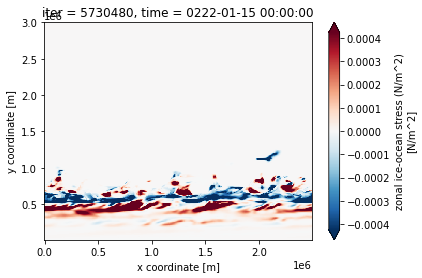

In [27]:
ds = pm.calcs.ice_ocean_stress(ds, path_to_input=path_to_input, thick_name="SI_Thick", fract_name="SI_Fract", taux_name="SIOtaux", tauy_name="SIOtauy")
ds.SIOtaux.isel(time=0, YC=slice(1,None)).plot(robust=True)

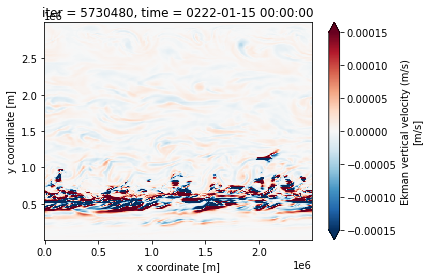

In [28]:
ds = pm.calcs.w_ekman(ds, path_to_input=path_to_input, taux_name="SIOtaux", tauy_name="SIOtauy", out_name="WVELEkIO")
ds.WVELEkIO.isel(time=0, YG=slice(1,None)).plot(robust=True)